In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        #A.augmentations.crops.transforms.RandomCrop(4,4),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 64
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

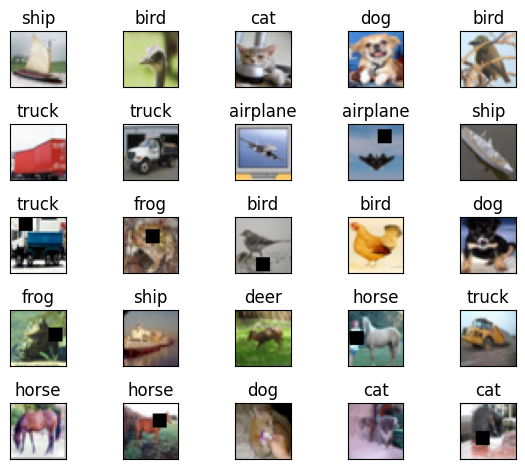

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


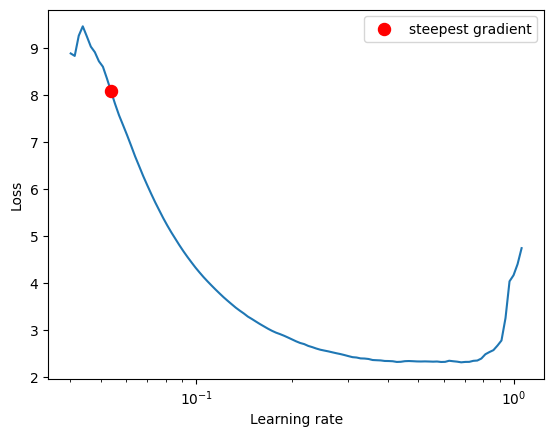

{'lr': [0.03,
  0.030888657798419976,
  0.0318036393529297,
  0.03274572442390028,
  0.033715715869707286,
  0.03471444033093821,
  0.035742748934867306,
  0.03680151802079855,
  0.03789164988689441,
  0.03901407355912734,
  0.040169745583008974,
  0.04135965083877188,
  0.04258480338069861,
  0.04384624730131324,
  0.045145057621172005,
  0.04648234120501112,
  0.04785923770503283,
  0.049276920532133256,
  0.05073659785589997,
  0.05223951363423142,
  0.05378694867345563,
  0.05538022171985167,
  0.05702069058350412,
  0.05870975329544823,
  0.060448849299091986,
  0.06223946067693039,
  0.0640831134135973,
  0.06598137869633147,
  0.06793587425396469,
  0.0699482657355735,
  0.07202026812996916,
  0.07415364722723565,
  0.0763502211235612,
  0.07861186177064594,
  0.08094049657100585,
  0.08333811002053286,
  0.08580674539971045,
  0.08834850651492678,
  0.09096555949136836,
  0.09366013461902305,
  0.09643452825336503,
  0.09929110477234183,
  0.10223229859133104,
  0.1052606162377

In [7]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion)
find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
optim_obj.define_scheduler(max_lr=5.38E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
target_test_acc = 93.


epoch: 1


  0%|          | 0/782 [00:00<?, ?it/s]/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.0475581884384155 batch_id=781 Accuracy = 57.34: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]


TypeError: ignored

Plot results for Batch Norm experiment

In [ ]:
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)